# Preprocess ECG 
We will now read in the reformatted data and preprocess the ECG data. 

## 1. Import packages and load the data 

In [5]:
import pandas as pd  # installing neurokit2 installs most other packages too
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pickle

In [6]:
# File path to raw data folder
raw_data_folder = '/Users/erwin/Documents/ProjectPsychophysiologyData/raw-data/'

# parameters
participants = ['sub-1', 'sub-2', 'sub-3']
tasks = ['baseline', 'spiderhand', 'spidervideo']


## 2. Concatenate data

Preprocessing operations will be applied to all data equally, regardless of which condition or which participant it is from. 
Thus, it is efficient to *concatenate*, or to stack the data next to each other, without having to point to multiple variable names. 

In [7]:
alldata = []

for pi in participants:
    for ti in tasks:
            
            # assemble file name 
            filename = raw_data_folder + '/' + pi + '_' + ti + '_ecg.csv'
            
            # read in the data in respective conditions
            subdata = pd.read_csv(filename)

            # append to the empty list
            alldata.append({"participant": pi, "condition": ti, "data": subdata})


## recap
We base our preprocessing steps on the description of **Pan-Tompkins algorithm**, that prepares the data for peak extraction. 

## 3. Create a band-pass filter and apply it to the data

The first step is to create a band-pass filter. 

> A band-pass filter is applied to increase the signal-to-noise ratio. A filter bandwidth of 5-15 Hz is suggested to maximize the QRS contribute and reduce muscle noise, baseline wander, powerline interference and the P wave/T wave frequency content. (wikipedia, Pan-Tompkins algorithm)

## 4. Derivative filter

Then we apply a simplyfied version of a derivative filter, that simply computes the difference between data points, which provides information on the slope of the changes. 

## 5. Squaring

As the next step, the filtered signal is squared to enhance the dominant peaks (QRSs) and reduce the possibility of erroneously recognizing a T wave as an R peak. 

We iterate over all data files, then visualize and example section of the data. 

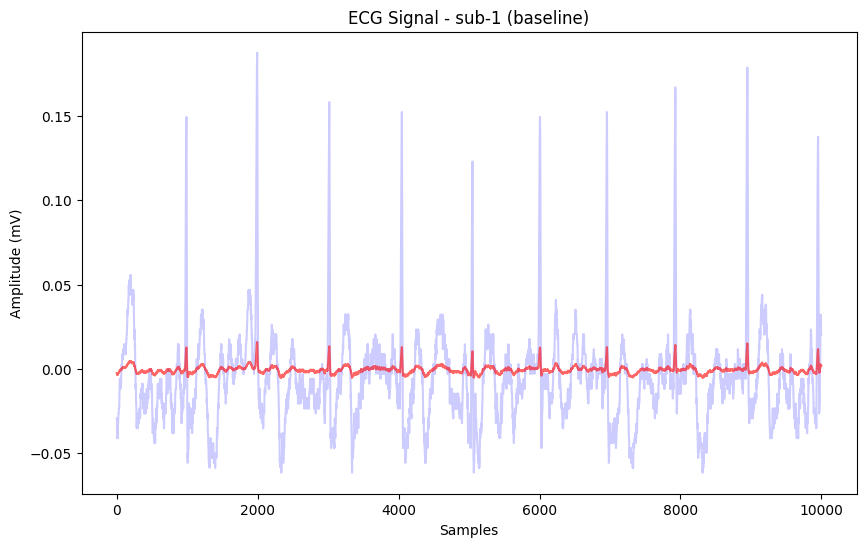

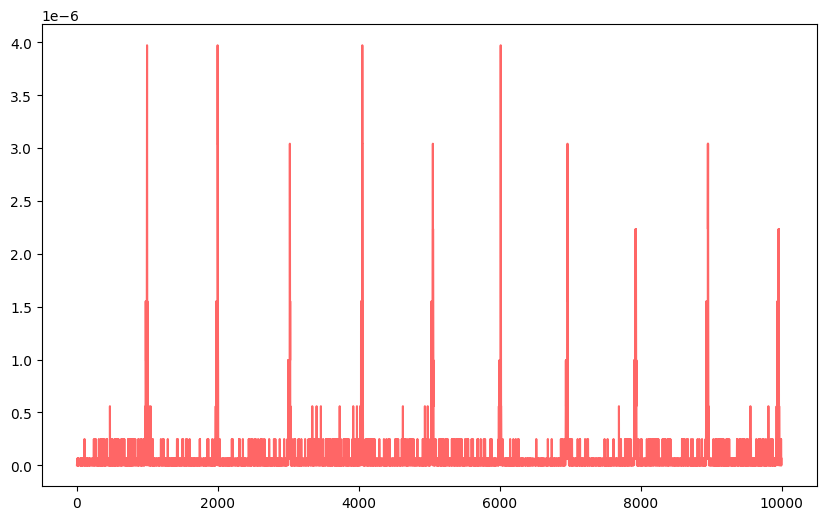

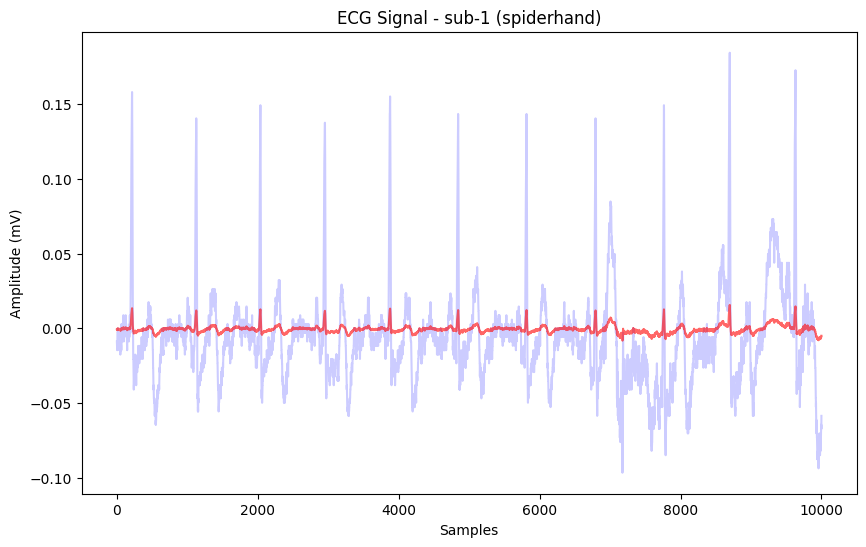

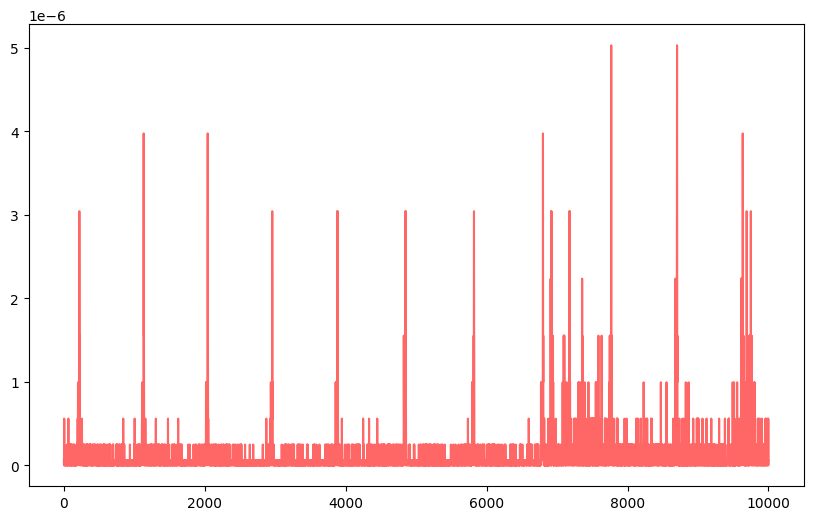

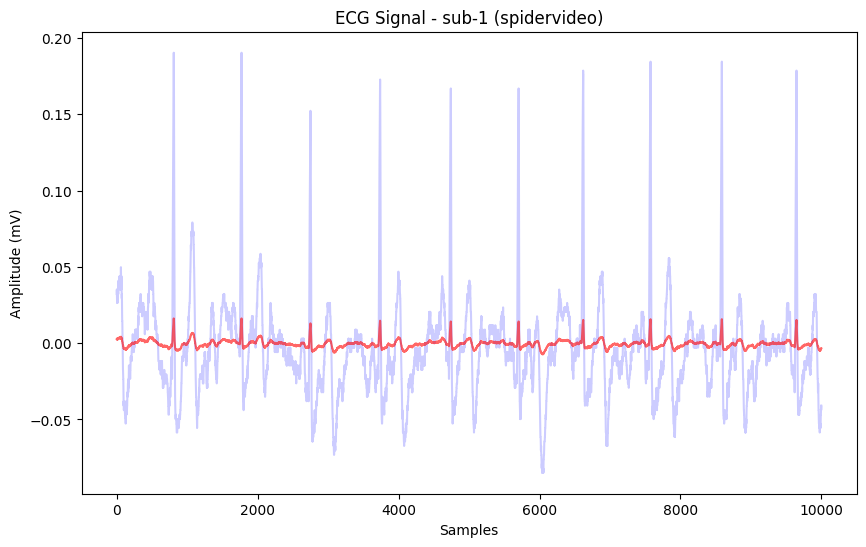

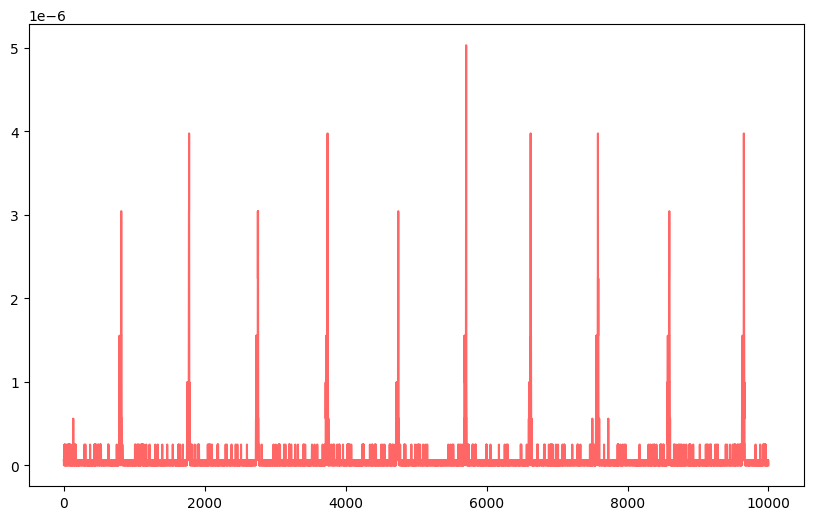

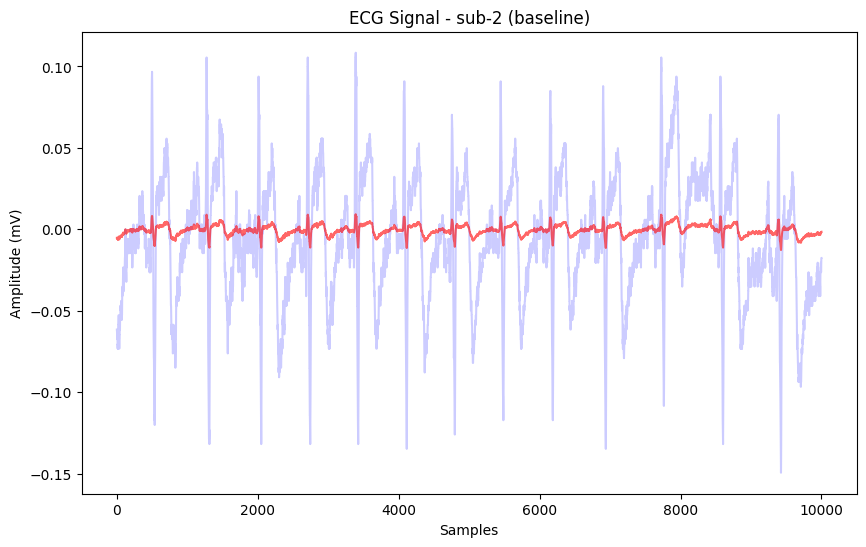

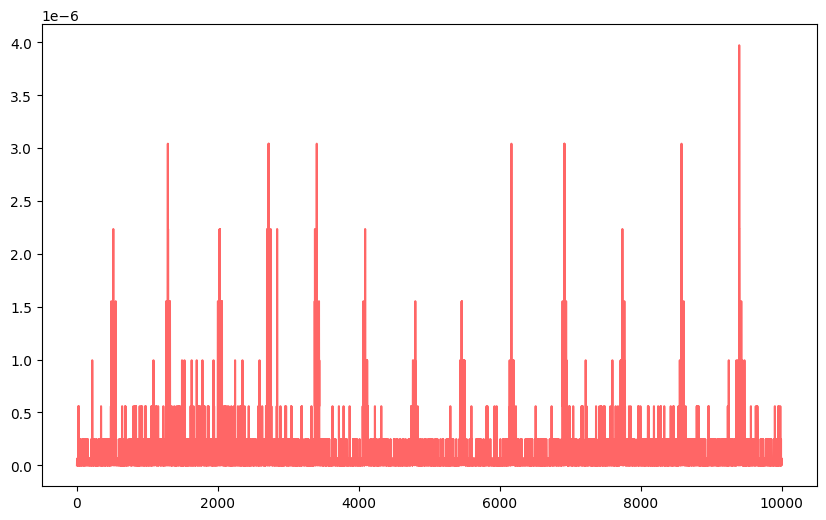

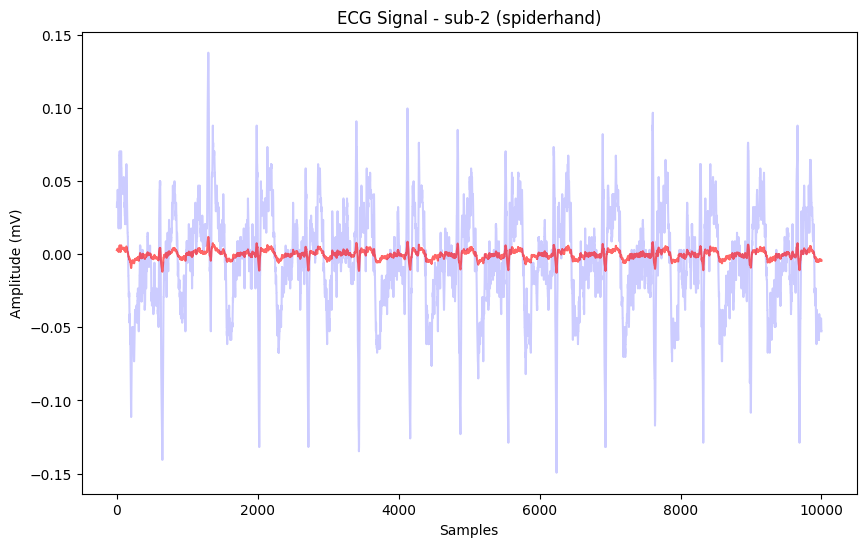

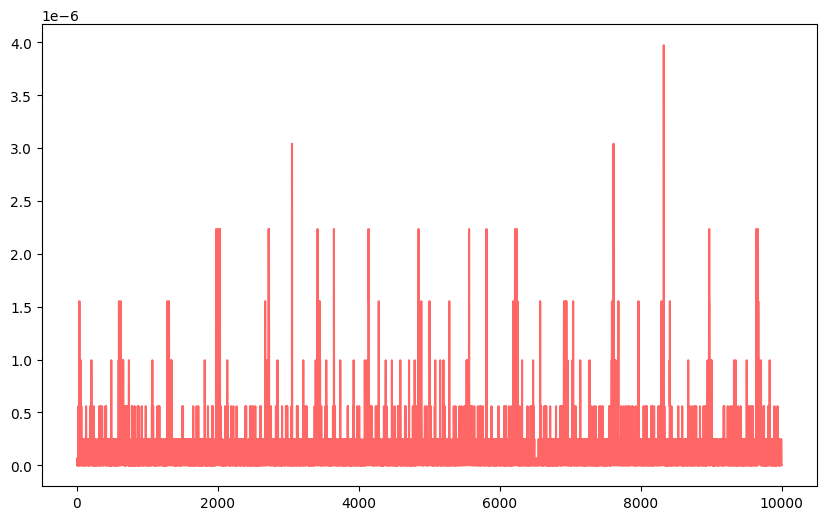

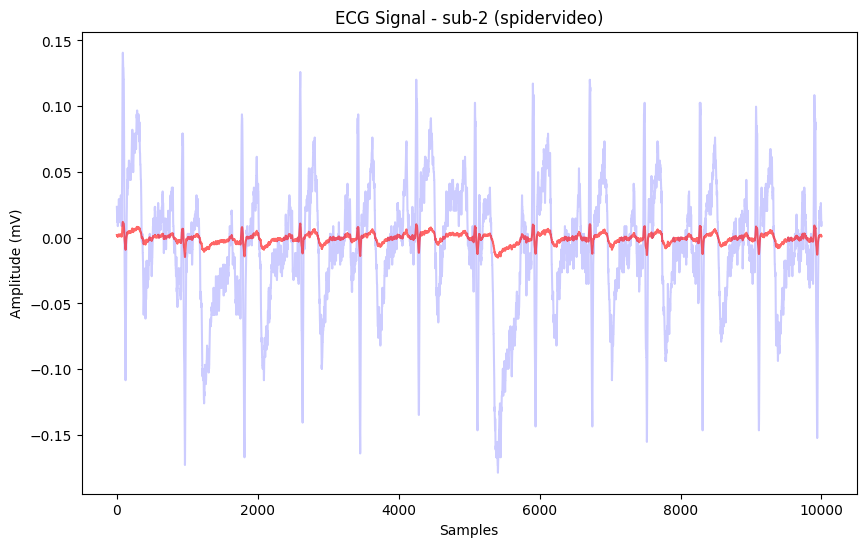

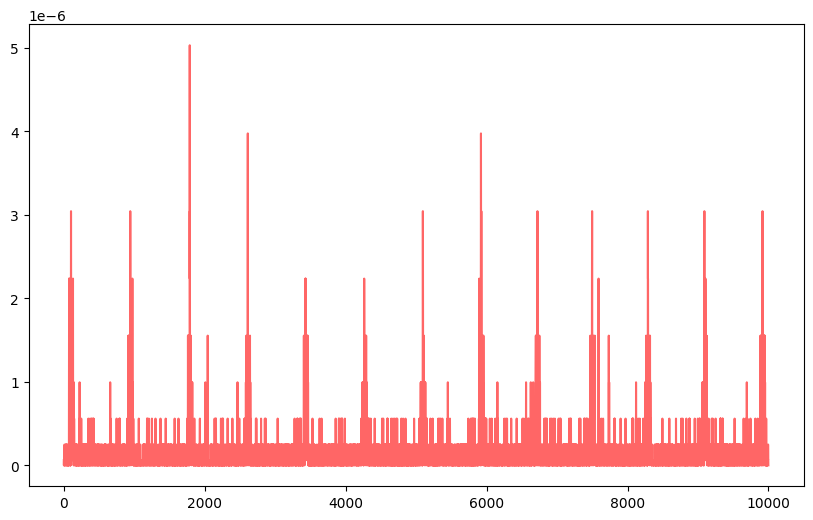

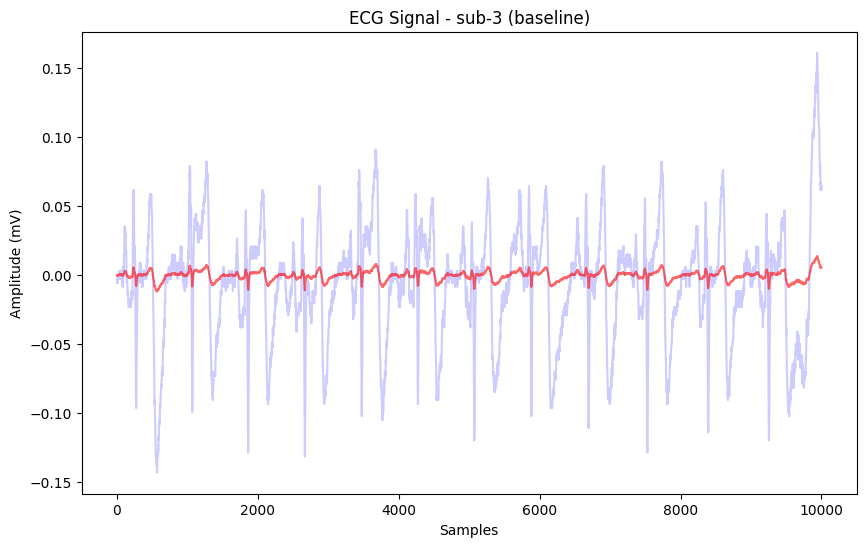

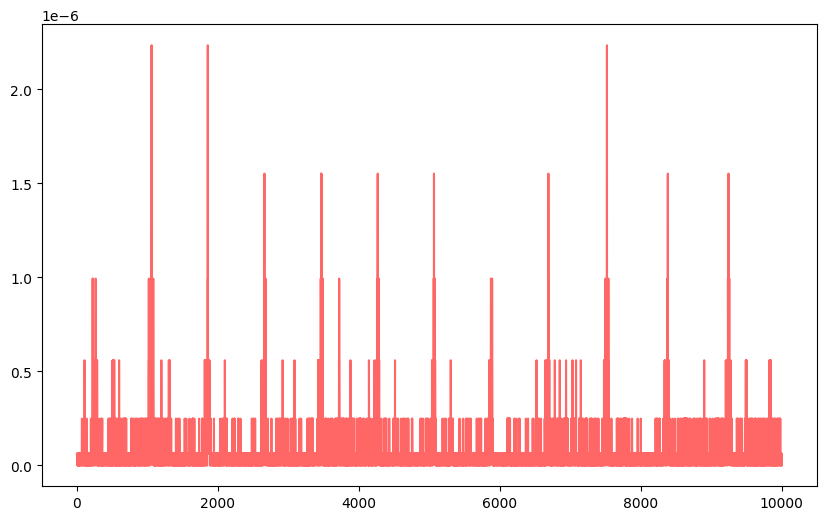

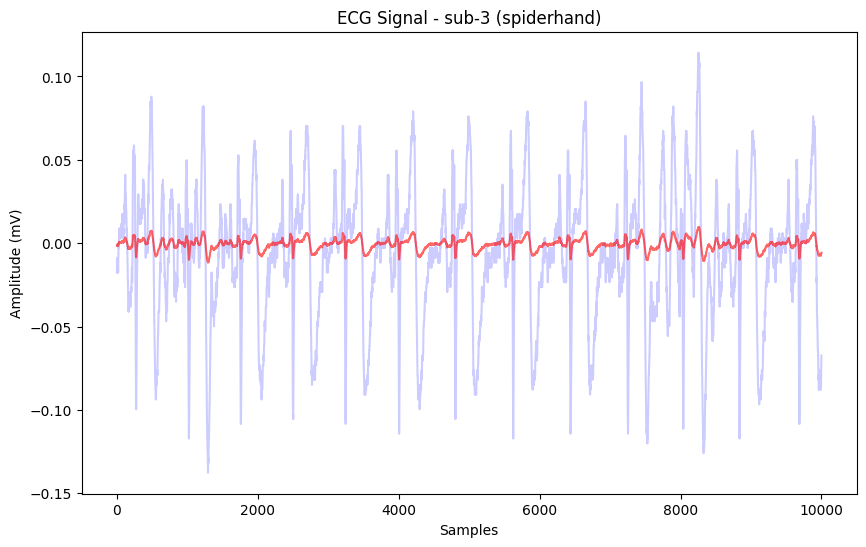

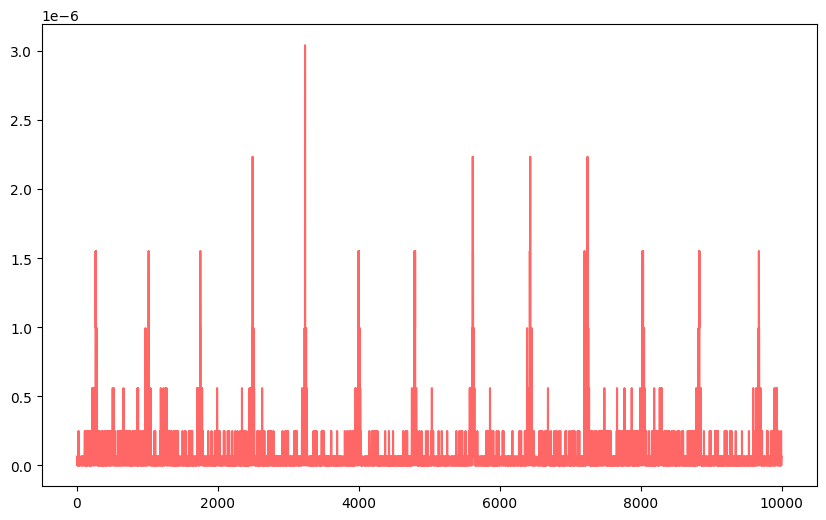

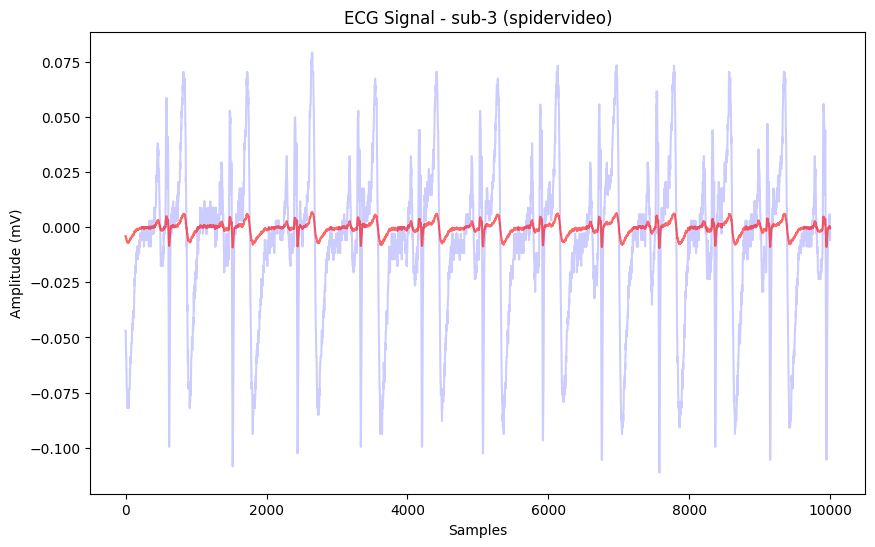

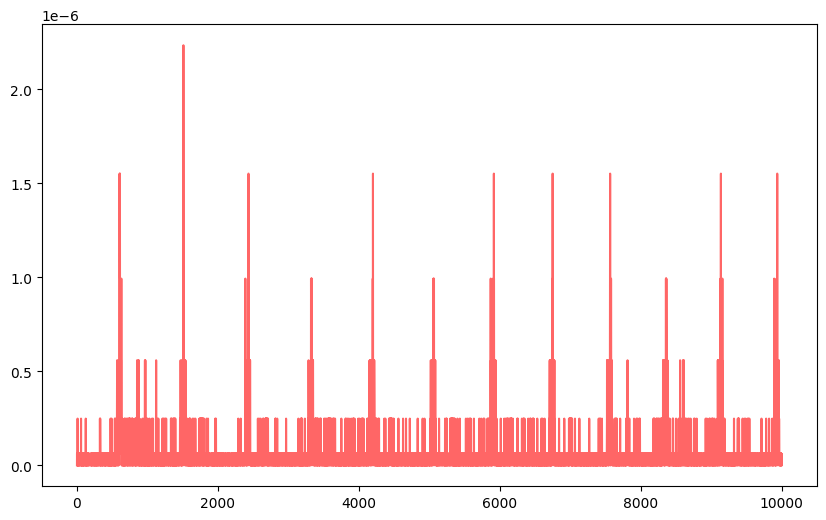

In [8]:
# parameters
fs = 1000  
lowcut = 0.5
highcut = 30.0

# create the Butterworth filter
b, a = signal.butter(1, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')

# Iterate over all participants in alldata
for participant_data in alldata:
    condition_name = participant_data["condition"]
    ecg_data = participant_data["data"]
    participnat_name = participant_data["participant"]
    
    # Apply the filter 
    filtered_ecg = signal.lfilter(b, a, ecg_data)
    derivative_ecg = np.diff(filtered_ecg.flatten()) 
    squared_ecg = np.square(derivative_ecg)  # or use filtered_ecg ** 2
    
    # Store the filtered data back into the participant's data dictionary
    participant_data["filtered_data"] = filtered_ecg
    participant_data["derive_sq_data"] = squared_ecg

    # Display the filtered ECG 
    plt.figure(figsize=(10, 6))
    
    # Plot the first 10 seconds 
    plt.plot(ecg_data.to_numpy()[10000:20000], label="Unfiltered ECG", color='blue', alpha=0.2)
    plt.plot(filtered_ecg[10000:20000], label="Filtered ECG", color='red', alpha=0.6)
    
    # Add title and labels
    plt.title(f"ECG Signal - {participant_data['participant']} ({condition_name})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
 
    # Display the diffsquared data 
    plt.figure(figsize=(10, 6))
    plt.plot(squared_ecg[10000:20000], label="Filtered ECG", color='red', alpha=0.6)
   

## 6. Save the data

In [5]:
# File path to derivative data folder
derivative_folder = '/Users/erwin/Documents/ProjectPsychophysiologyData/preprocessed-data/'
output_filename   = derivative_folder + 'preprocessed_ecg.pkl'

# Save alldata as a pickle file
with open(output_filename, 'wb') as f:
    pickle.dump(alldata, f)